In [1]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [3]:
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.4
print('The current PyMC version is', pymc.__version__) # 2.3.8
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

The current HDDM version is 0.8.0
The current Kabuki version is 0.6.4
The current PyMC version is 2.3.8
The current Numpy version is 1.20.3
The current Pandas version is 1.3.5
The current seaborn version is 0.11.2


Maybe the generation way of simulated data should make a difference.

In the past scripts, we use the way:
 
$$parameter_{j}=\beta_{0,j} + \beta_{1,j}*C(condition)$$

$$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $$

$$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$$

So, we can test which data structure is useful, we generate the data from the simplest way(without condition)

# the simplest model

Instead of generate the subject params via sample param form a distribution with the group params, we sample the random error from the group error distribution. And then add the subject error to the group params.

In [10]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 200

# set the group parameter
# intercept and slope of v
v_int = 1
v_sig = 0.05
# intercept and slope of z
z_int = 0.5
z_sig = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.2
t_sig = 0.05

In [11]:
# set the subject parameter
# v
v_err_subj = np.random.normal(0,v_sig,n_subjects)
# z
z_err_subj = np.random.normal(0,z_sig,n_subjects)
# a
a_err_subj = np.random.normal(0,a_sig,n_subjects)
# t
t_err_subj = np.random.normal(0,t_sig,n_subjects)

# dataframe
df = pd.DataFrame()
param = pd.DataFrame()
for i in range(n_subjects):
    
    # v of subject 
    v  = v_int + v_err_subj[i]
    # z of subject
    z  = z_int + z_err_subj[i]
    # the default parameter a
    a  = a_int + a_err_subj[i]
    # the default parameter t
    t  = t_int + t_err_subj[i]
    
    # set up parameters of DDM for four levels 
    level = {'v':v, 'a':a, 't':t, 'z':z, 'sv':0, 'sz':0, 'st':0}
    
    # generate simulated data
    np.random.seed(123)
    data, params = hddm.generate.gen_rand_data({'level':level},
                                                 size = trials_per_level
                                                  )
    # data
    data['subj_idx'] = i
    df = df.append(data)
    
    # params
    # create dataframe
    params = pd.DataFrame([params])
    # add subject
    params['subj_idx'] = i
    # combine params
    param = param.append(params)

Text(0.5, 1.0, 't')

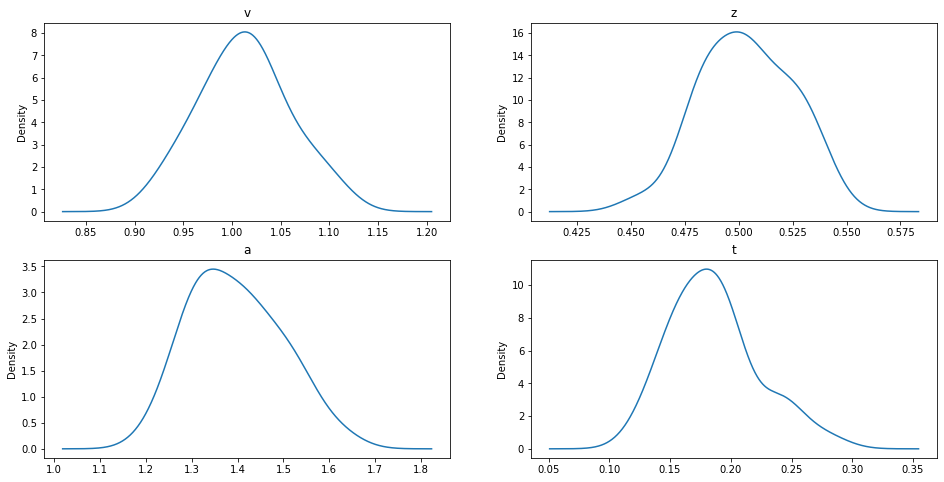

In [6]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 8))
# v
param.v.plot.kde(ax=ax[0,0])
ax[0,0].set_title('v')
# z
param.z.plot.kde(ax=ax[0,1])
ax[0,1].set_title('z')
# a
param.a.plot.kde(ax=ax[1,0])
ax[1,0].set_title('a')
# t
param.t.plot.kde(ax=ax[1,1])
ax[1,1].set_title('t')

subj_idx
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23

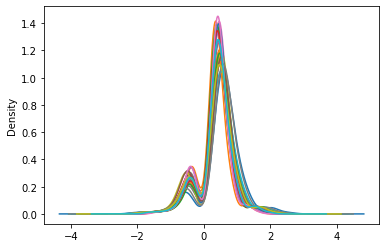

In [7]:
# flip the rt of response 0
df.loc[df['response']==0,'rt']=-df.loc[df['response']==0,'rt']
# the rt distribution
df.groupby(['subj_idx']).rt.plot.kde()

In [8]:
# contrust model
m1 = bmb.Model("v ~ 1 + (1|subj_idx)", data=param)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 8 seconds.
There were 1152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5119621146589804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 393 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71468341319808, but should be close to 0.8. Try to increase the number of tuning steps.
There were 240 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1077 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5747135859662621, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


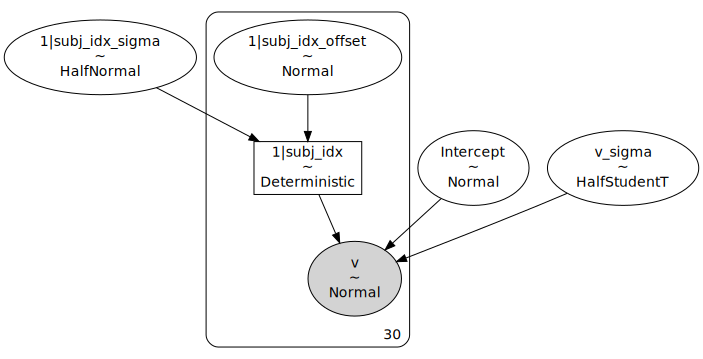

In [9]:
m1.build()
m1.graph()

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>], dtype=object)

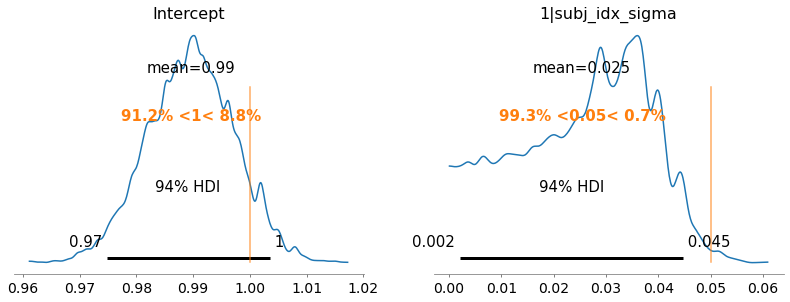

In [10]:
az.plot_posterior(res1, 
                  var_names=['Intercept','1|subj_idx_sigma'], 
                  ref_val=[v_int,v_sig]
                 )

In [7]:
 def ms1(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
    '''
    id: the id of cpu thread
    df: the input data
    samples: number of samples for MCMC
    burn: number of burn-in of MCMC
    thin: number of thin
    save_name: prefix of file name when saving the model object
    '''
    print('running chain {:d} for model {}'.format(id, save_name))
    # the database file
    dbname = save_name + '_chain_%i.db'%id
    # the model object store here
    mname = save_name + '_chain_%i'%id
    
    v_reg = {'model':'v~1','link_func':lambda x:x}
    z_reg = {'model':'z~1','link_func':lambda x:x}
    reg_descr = [v_reg, 
                 z_reg]
    m = hddm.HDDMRegressor(df, 
                           reg_descr, 
                           include=['z'],
                           group_only_regressors=False,
                           keep_regressor_trace=True
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save
    m.save(mname)

    return m

In [9]:
samples = 4000    # number of MCMC sample
burn = 1000       # number of burn in
nppc = 500        # number of posterior predictive
thin = 2           # thining
chains = 4         # number of chains
savefile= True     # save file or not, only "True" is available for now.
savetag = None     # tag added to saved files.
model_func = [ms1]

In [ ]:
ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=2000,burn = 1000,thin=2, save_name = 'ms1' ) for i in range(4))

In [ ]:
%%time
models, InfData = HDDMarviz(data=df, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains,
                            savetag=savetag)

start model fitting for ms1


  0%|          | 0/4 [00:00<?, ?it/s]

running chain 0 for model ms1
Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
running chain 1 for model ms1
Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
running chain 2 for model ms1
Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']
running chain 3 for model ms1
Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['a_Intercept']
Adding these covariates:
['t_Intercept']


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -----------------44%                  ] 1798 of 4000 complete in 7611.6 sec              0%                  ] 2 of 4000 complete in 4.1 sec[                  0%                  ] 2 of 4000 complete in 4.0 sec[                  0%                  ] 2 of 4000 complete in 4.0 sec[                  0%                  ] 3 of 4000 complete in 8.0 sec[                  0%                  ] 3 of 4000 complete in 8.1 sec[                  0%                  ] 3 of 4000 complete in 8.0 sec[                  0%                  ] 3 of 4000 complete in 8.2 sec[                  0%                  ] 4 of 4000 complete in 12.0 sec[                  0%                  ] 4 of 4000 complete in 12.3 sec[                  0%                  ] 4 of 4000 complete in 12.3 sec[                  0%                  ] 4 of 4000 complete in 12.6 sec[                  0%                  ] 5 of 4000 complete in 16.0 sec[                  0%                  ] 5 of 4000 complete in 16.4 sec[            

In [14]:
az.plot_trace(InfData['ms1'])

NameError: name 'InfData' is not defined

In [ ]:
%%time
# number of chains
chains=4
# file name
file_names = glob.glob('ms1'+'_chain_*[!db]',recursive=False)
# if there exists file, pass
if file_names:
    # sort filename by id
    file_names = sorted(file_names, key = lambda x:x[-1])
    ms1res = []
    for fname in file_names:
        print('current loading:',fname,'\n')
        ms1res.append(hddm.load(fname))
# else sample
else:
    ms1res = Parallel(n_jobs = 4)(delayed(ms1)(id = i, df = df, samples=2000,burn = 1000,thin=1, save_name = 'ms1' ) for i in range(4))

current loading: ms1_chain_0 

current loading: ms1_chain_1 

current loading: ms1_chain_2 

current loading: ms1_chain_3 



In [4]:
ms1res=hddm.load('ms1_chain_0')

Plotting v_Intercept
Plotting v_Intercept_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting t_Intercept
Plotting t_Intercept_std


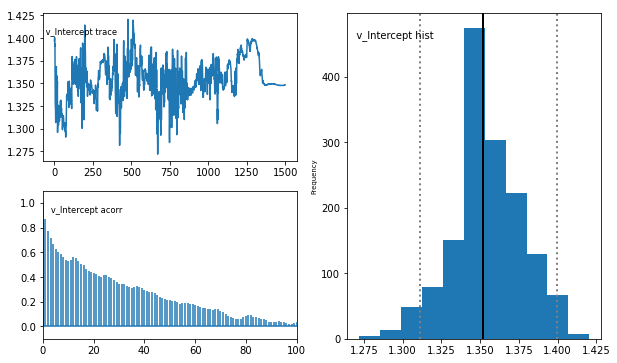

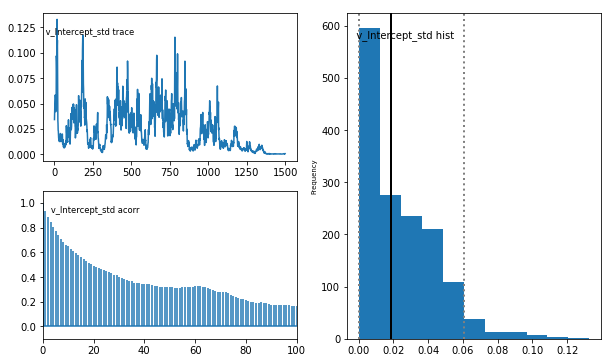

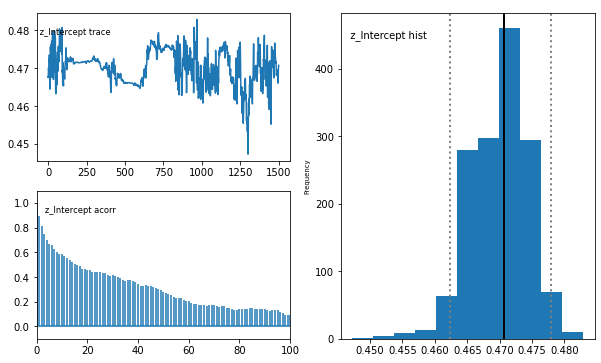

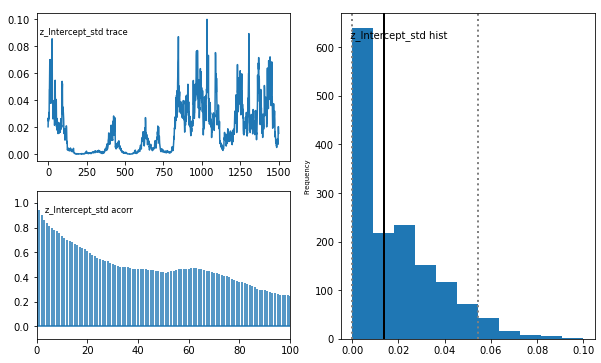

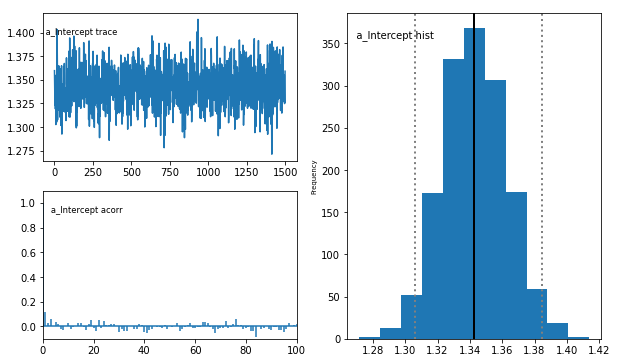

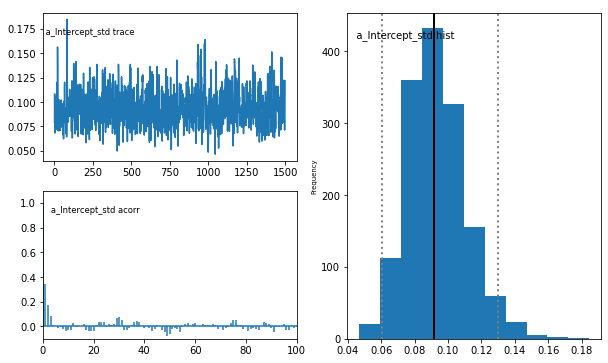

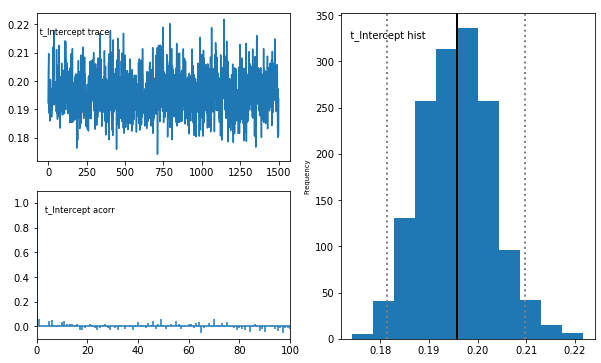

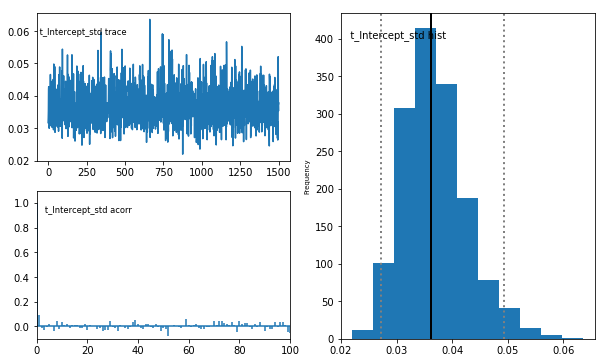

In [6]:
ms1res.plot_posteriors()

In [5]:
m1 = kabuki.utils.concat_models(ms1res)
m1.plot_posteriors()

KeyError: 0